In [1]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

from rsq import AgglomerativeEnsemble
from rsq.helpers import stratified_sample, few_shot_sample

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

def exp(n_unlabeled=100, n_labeled_per_class=1, noise=0.1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    accuracies = np.zeros(6)
    
    n_labeled=2*n_labeled_per_class
    
    X, y = make_moons(10, noise=noise)
    X_labeled_1 = X[np.where(y == 0)[0][:n_labeled_per_class]]
    X_labeled_2 = X[np.where(y == 1)[0][:n_labeled_per_class]]
    X_labeled = np.concatenate((X_labeled_1, X_labeled_2), axis=0)
    
    del X, y
    
    y_labeled = np.concatenate((np.zeros(n_labeled_per_class), np.ones(n_labeled_per_class)))
    
    X, y = make_moons(10000, noise=noise)
    perm = np.random.choice(10000, 10000, replace=False)
    X_unlabeled = X[:n_unlabeled]
    y_unlabeled = y[:n_unlabeled]
        
    X_test, y_test = make_moons(1000, noise=noise)
    
    clf=SVC()
    clf.fit(X_labeled, y_labeled)
    y_hat=clf.predict(X_test)
    accuracies[1] = (y_test == y_hat).mean()
    
    
    clf=DecisionTreeClassifier()
    clf.fit(X_labeled, y_labeled)
    y_hat=clf.predict(X_test)
    accuracies[2] = (y_test == y_hat).mean()
    
    
    clf=KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    clf.fit(X_labeled, y_labeled)
    y_hat=clf.predict(X_test)
    accuracies[3] = (y_test == y_hat).mean()

    
    y_ = -1 * np.ones(n_labeled + n_unlabeled)
    y_[:n_labeled] = y_labeled.copy()

    n_neighbors = max([1, int(np.math.floor(np.log(len(y_))))])
    clf=AgglomerativeEnsemble(n_estimators=1, p_inbag=1, affinity='euclidean', linkage='single', n_neighbors=1, gem_p=128)
    clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
    y_hat=clf.predict(X_test)
    accuracies[0] = (y_test == y_hat).mean()
    
    clf=LabelPropagation(n_neighbors=1)
    clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
    y_hat=clf.predict(X_test)
    accuracies[4] = (y_test == y_hat).mean()
    
    clf=LabelSpreading(n_neighbors=1)
    clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
    y_hat=clf.predict(X_test)
    accuracies[5] = (y_test == y_hat).mean()
    
        
    print(accuracies)

    return accuracies

0.226
0.948


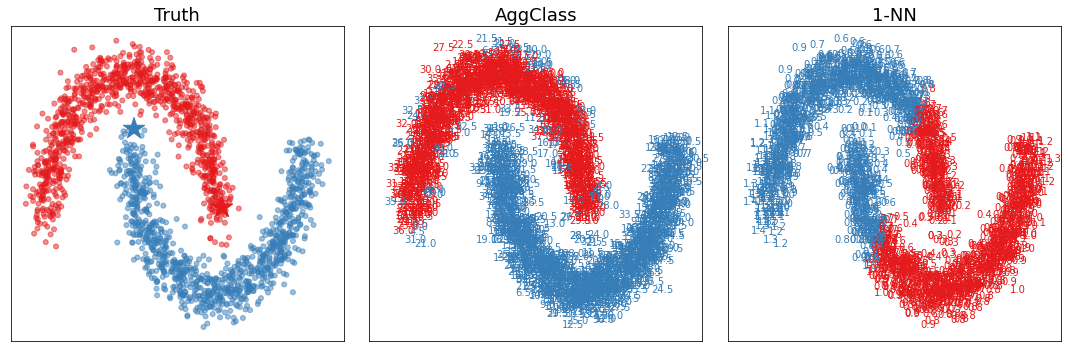

In [11]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
n_labeled=2

colors=sns.color_palette("Set1", n_colors=2)

np.random.seed(15)

fontsize=18
n_labeled_per_class=1

n_labeled=2*n_labeled_per_class
n_unlabeled=2000
    
at_least_n_labeled_per_class = False
while not at_least_n_labeled_per_class:
    X_labeled, y_labeled = make_moons(n_labeled, noise=0.1)

    if len(np.where(y_labeled == 1)[0]) >= n_labeled_per_class and len(np.where(y_labeled == 0)[0]) >= n_labeled_per_class:
        at_least_n_labeled_per_class=True

X_unlabeled, y_unlabeled = make_moons(n_unlabeled, noise=0.1)
X = np.concatenate((X_labeled, X_unlabeled), axis=0)
y = np.concatenate((y_labeled, y_unlabeled))

y_ = -1 * np.ones(n_labeled + n_unlabeled)
y_[:n_labeled] = y_labeled.copy()
        
X_test, y_test = make_moons(500, noise=0.1)
s=25

clf=KNeighborsClassifier(n_neighbors=1)
clf.fit(X_labeled, y_labeled)
y_hat=clf.predict(X_test)
print((y_hat == y_test).mean())
y_hat=clf.predict(X)
ax[2].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s, alpha=0)
ax[2].set_title('1-NN', fontsize=fontsize)
dists = np.stack([np.linalg.norm(X - xl, axis=1) for xl in X_labeled]).T

min_dists = np.min(dists, axis=1)

for i, d in enumerate(min_dists):
    ax[2].text(X[i, 0], X[i, 1], s='%1.1f'%(d), c=colors[y_hat[i]])


        
ax[0].scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=np.array(colors)[np.array([0,1])][y_unlabeled.astype(int)], s=s, alpha=0.5)
ax[0].scatter(X_labeled[:, 0], X_labeled[:, 1], c=np.array(colors)[np.array([0,1])][y_labeled.astype(int)], marker='*', s=500)
ax[0].set_title('Truth', fontsize=fontsize)

clf=AgglomerativeEnsemble(n_estimators=1, p_inbag=1, affinity='euclidean', linkage='single', 
                          n_neighbors=1, gem_p=32, classes=np.array([0,1]))
clf.fit(X, y_)
y_hat=clf.predict(X_test)
print((y_hat == y_test).mean())
y_hat=clf.predict(X)
ax[1].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s, alpha=0)
ax[1].set_title('AggClass', fontsize=fontsize)

min_tree_dists = np.min(clf.ensemble[0].tree_distances, axis=1)

for i, mtd in enumerate(min_tree_dists):
    ax[1].text(X[i, 0], X[i, 1], s='%1.1f'%(mtd), c=colors[y_hat[i]])
    
for ax_ in ax:
    ax_.set_yticks([])
    ax_.set_xticks([])


plt.tight_layout()

In [8]:
min_dists.shape, min_tree_dists.shape, X_test.shape

((2002,), (2002,), (500, 2))

In [ ]:
0.67*200